In [252]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
rng = np.random.RandomState(1)

# Example preparation
* https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-noisy-targets-py
* https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_prior_posterior.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-prior-posterior-py

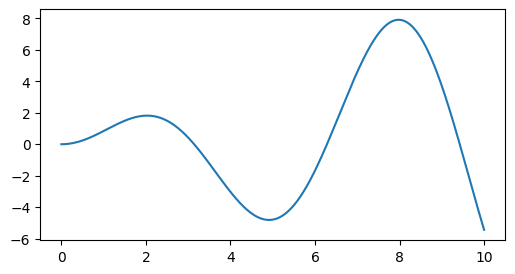

In [253]:
X = np.linspace(0, 10, 1000).reshape(-1, 1)
y = np.squeeze(X*np.sin(X))

fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(X, y)

fig.savefig("./122_gpr2_1.png")

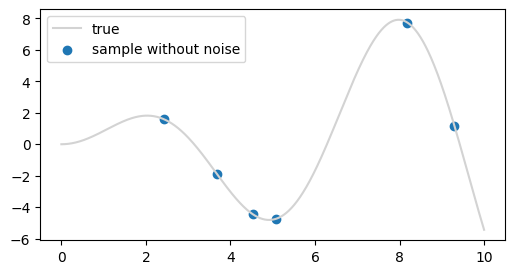

In [254]:
# sample
training_indices = rng.choice(np.arange(y.size), size=6, replace=False)
X_train = X[training_indices]
y_train = y[training_indices]

# visualization
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(X, y, c="lightgray", label="true")
ax.scatter(X_train, y_train, label="sample without noise")
ax.legend()

fig.savefig("./122_gpr2_2.png")

In [255]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = 1*RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gpr = GaussianProcessRegressor(kernel, n_restarts_optimizer=9, random_state=0)
gpr.fit(X_train, y_train)
print(gpr.kernel_)

5.02**2 * RBF(length_scale=1.43)


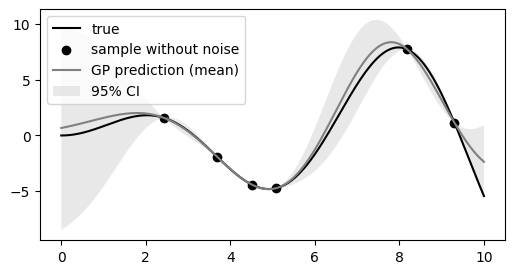

In [256]:
# prediction
y_pred_mean, y_pred_std = gpr.predict(X, return_std=True)

# visualization
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(X, y, c="k", label="true")
ax.scatter(X_train, y_train, fc="k", label="sample without noise")

ax.plot(X.ravel(), y_pred_mean, c="0.5", label="GP prediction (mean)")
ax.fill_between(X.ravel(), y_pred_mean-1.96*y_pred_std, y_pred_mean+1.96*y_pred_std, alpha=0.5, fc="lightgray", label="95% CI")
ax.legend(loc="upper left")

fig.savefig("./122_gpr2_3.png")

In [257]:
# sample
n_samples=5
y_samples = gpr.sample_y(X, n_samples)

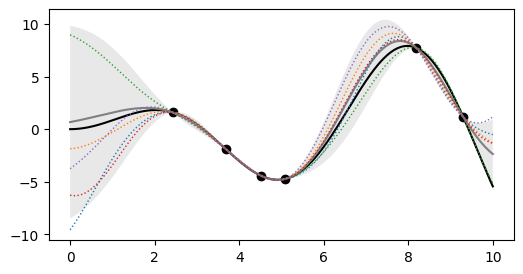

In [258]:
# prediction
y_pred_mean, y_pred_std = gpr.predict(X, return_std=True)

# visualization
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(X, y, c="k", label="true")
ax.scatter(X_train, y_train, fc="k", label="sample without noise")

ax.plot(X.ravel(), y_pred_mean, c="0.5", label="GP prediction (mean)")
ax.fill_between(X.ravel(), y_pred_mean-1.96*y_pred_std, y_pred_mean+1.96*y_pred_std, alpha=0.5, fc="lightgray", label="95% CI")

for y_sample in y_samples.T:
    ax.plot(X.ravel(), y_sample, lw=1, ls=":", label="GP prediction (mean)")
    
fig.savefig("./122_gpr2_4.png")    

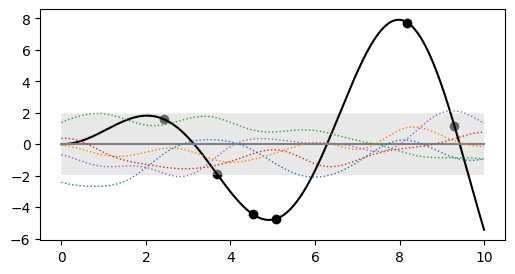

In [259]:
# prior

kernel = 1*RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gpr = GaussianProcessRegressor(kernel, n_restarts_optimizer=9, random_state=0)

# prediction
y_pred_mean, y_pred_std = gpr.predict(X, return_std=True)

# visualization
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(X, y, c="k", label="true")
ax.scatter(X_train, y_train, fc="k", label="sample without noise")

ax.plot(X.ravel(), y_pred_mean, c="0.5", label="GP prediction (mean)")
ax.fill_between(X.ravel(), y_pred_mean-1.96*y_pred_std, y_pred_mean+1.96*y_pred_std, alpha=0.5, fc="lightgray", label="95% CI")

y_samples = gpr.sample_y(X, n_samples)
for y_sample in y_samples.T:
    ax.plot(X.ravel(), y_sample, lw=1, ls=":", label="GP prediction (mean)")
    
fig.savefig("./122_gpr2_5.png")  

# Kernels

In [263]:
plt.rcParams['mathtext.fontset'] = "cm"

def plot_pp(kernel, kernel_name="", X_train=X_train, y_train=y_train, X_true=X, y_true=y, n_samples=5):
    gpr = GaussianProcessRegressor(kernel, n_restarts_optimizer=9, random_state=0)
    
    # prior
    y_prior_mean, y_prior_std = gpr.predict(X_true, return_std=True)
    y_prior_samples = gpr.sample_y(X_true, n_samples)
    
    # posterior
    gpr.fit(X_train, y_train)
    y_posterior_mean, y_posterior_std = gpr.predict(X_true, return_std=True)
    y_posterior_samples = gpr.sample_y(X_true, n_samples)
    
    # kernel after fitting
    kernel_ = gpr.kernel_
    theta = gpr.kernel_.theta
    ll = gpr.log_marginal_likelihood(theta)
    
    # visualize
    fig, axs = plt.subplots(nrows=2, figsize=(6, 4), sharex=True, sharey=True, constrained_layout=True)
    for ax, y_mean, y_std, y_samples, title, k in zip(axs, [y_prior_mean, y_posterior_mean], 
                                                           [y_prior_std, y_posterior_std], [y_prior_samples, y_posterior_samples],
                                                           ["prior", "posterior"], [kernel, kernel_]):
        # true
        ax.plot(X_true, y_true, c="k")
        ax.scatter(X_train, y_train, fc="k")
        
        # pred
        ax.plot(X_true.ravel(), y_mean, c="0.5")
        ax.fill_between(X_true.ravel(), y_mean-1.96*y_std, y_mean+1.96*y_std, alpha=0.5, fc="lightgray")
        
        # samples
        for y_sample in y_samples.T:
            ax.plot(X_true.ravel(), y_sample, lw=1, ls=":")
    
        # title
        ax.text(0.18, 0.97, title, fontsize="large", fontweight="bold", color="b", ha="right", va="top", transform=ax.transAxes)
        str_k = str(k).replace(' ** ','^').replace('**','^').replace('*','\cdot').replace('length_scale','l').replace('alpha','\\alpha').replace('periodicity', 'p').replace('sigma','\\sigma').replace('nu','\\nu').replace("_level", "\\_level")
        ax.text(0.2, 0.97, "kernel: " + f"${str_k}$", ha="left", va="top", color="darkblue", transform=ax.transAxes)
        
    axs[1].text(0.105, 0.84, "Log-likelihood: " + f"${{{ll:.3f}}}$", ha="left", va="top", color="darkblue", transform=axs[1].transAxes)
    str_theta = ", ".join([f"{t:.3f}" for t in theta])
    axs[1].text(0.265, 0.71, f"$\\theta: ({{{str_theta}}})$", ha="left", va="top", color="darkblue", transform=axs[1].transAxes)
    fig.suptitle(kernel_name, fontsize="x-large")
    
    return fig

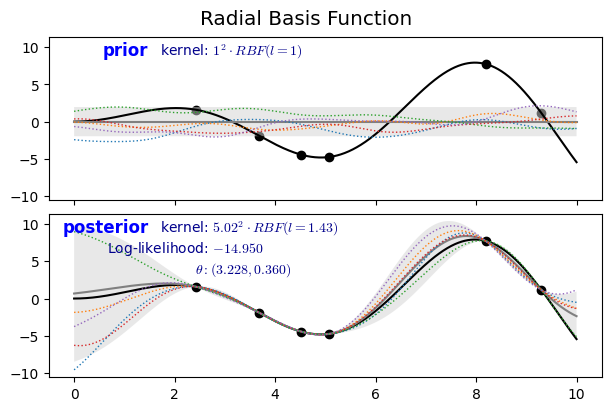

In [261]:
kernel = 1*RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
fig = plot_pp(kernel, "Radial Basis Function")
fig.savefig("./122_gpr2_6.png")  

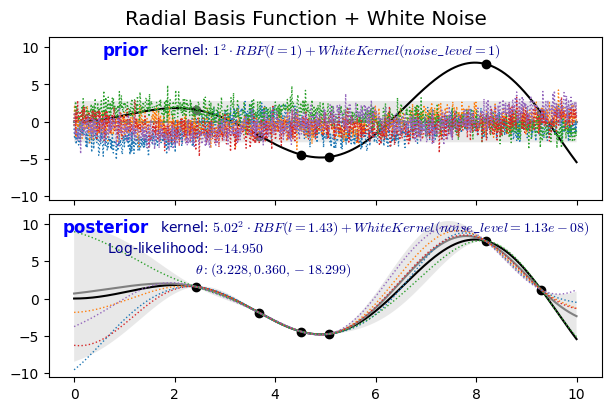

In [264]:
from sklearn.gaussian_process.kernels import WhiteKernel

kernel = 1*RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-8, 1e1))
fig = plot_pp(kernel, "Radial Basis Function + White Noise")
fig.savefig("./122_gpr2_11.png")  

/opt/conda/envs/py39/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:479: RuntimeWarning: covariance is not positive-semidefinite.
  y_samples = rng.multivariate_normal(y_mean, y_cov, n_samples).T


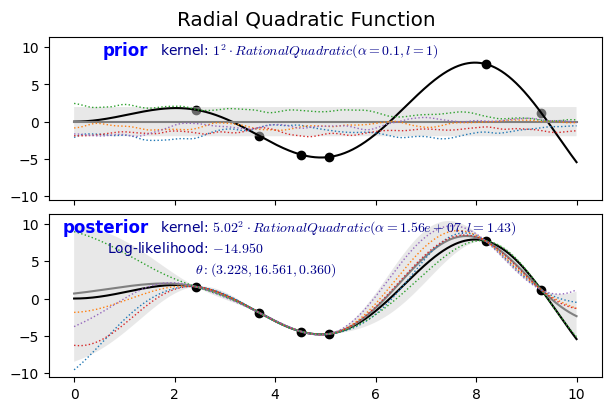

In [138]:
from sklearn.gaussian_process.kernels import RationalQuadratic

kernel = 1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1, alpha_bounds=(1e-5, 1e15))
fig = plot_pp(kernel, "Radial Quadratic Function")
fig.savefig("./122_gpr2_7.png")  

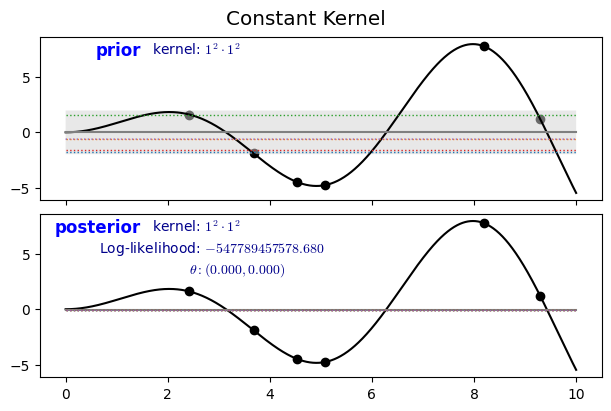

In [266]:
from sklearn.gaussian_process.kernels import ConstantKernel

kernel = 1.0 * ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-5, 1e15))
fig = plot_pp(kernel, "Constant Kernel")
fig.savefig("./122_gpr2_15.png")  

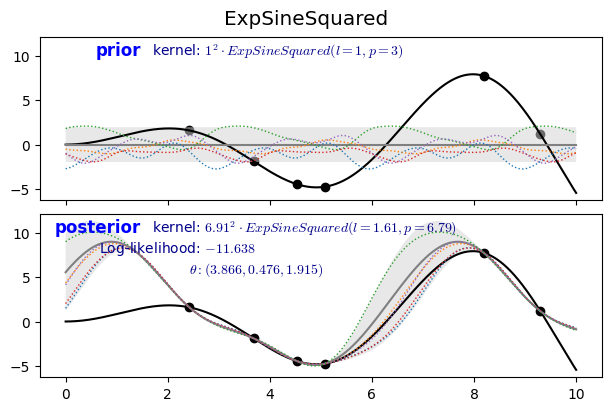

In [145]:
from sklearn.gaussian_process.kernels import ExpSineSquared

kernel = 1.0 * ExpSineSquared(
    length_scale=1.0,
    periodicity=3.0,
    length_scale_bounds=(0.1, 10.0),
    periodicity_bounds=(1.0, 10.0),
)
fig = plot_pp(kernel, "ExpSineSquared")
fig.savefig("./122_gpr2_8.png")  

/opt/conda/envs/py39/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


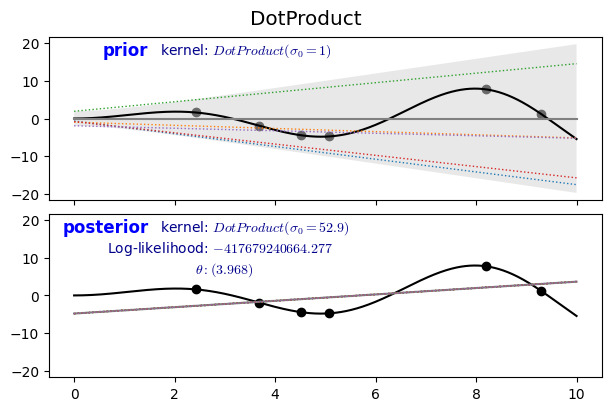

In [146]:
from sklearn.gaussian_process.kernels import DotProduct

kernel = DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 100.0))
fig = plot_pp(kernel, "DotProduct")
fig.savefig("./122_gpr2_9.png")  

/opt/conda/envs/py39/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:479: RuntimeWarning: covariance is not positive-semidefinite.
  y_samples = rng.multivariate_normal(y_mean, y_cov, n_samples).T
/opt/conda/envs/py39/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/conda/envs/py39/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:432: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(
/opt/conda/envs/py39/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:479: RuntimeWarning: covariance is not positive-semidefinite.
  y_samples = rng.multivariate_normal(y_mean, y_cov, n_samples).T


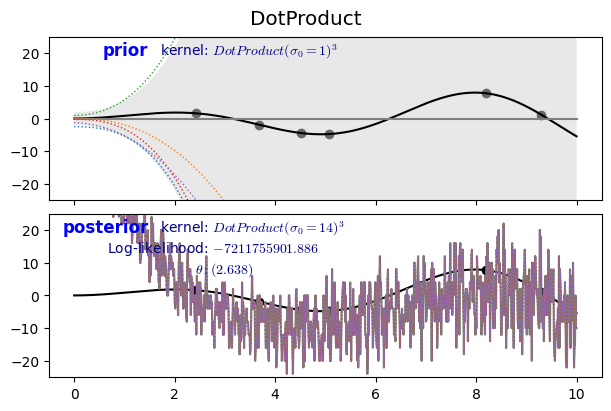

In [270]:
## 3차
kernel = DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 100.0))**3
fig = plot_pp(kernel, "DotProduct")
fig.axes[1].set_ylim(-25, 25)
fig.savefig("./122_gpr2_16.png") 

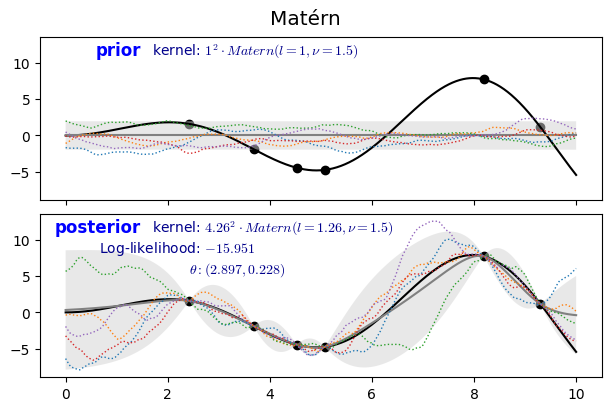

In [147]:
from sklearn.gaussian_process.kernels import Matern

kernel = 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)
fig = plot_pp(kernel, "Matérn")
fig.savefig("./122_gpr2_10.png")

# Long-Term Prediction
* https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-co2-py

In [149]:
from sklearn.datasets import fetch_openml

co2 = fetch_openml(data_id=41187, as_frame=True)
co2.frame.head()

,year,month,day,weight,flag,station,co2
0,1958.0,3.0,29.0,4.0,0.0,MLO,316.1
1,1958.0,4.0,5.0,6.0,0.0,MLO,317.3
2,1958.0,4.0,12.0,4.0,0.0,MLO,317.6
3,1958.0,4.0,19.0,6.0,0.0,MLO,317.5
4,1958.0,4.0,26.0,2.0,0.0,MLO,316.4


In [162]:
import pandas as pd

co2_data = co2.frame
co2_data["date"] = pd.to_datetime(co2_data[["year", "month", "day"]])
co2_data = co2_data[["date", "co2"]].set_index("date")
print(co2_data.shape)
co2_data.head()

(2225, 1)


,co2
date,
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [163]:
co2_data.index.min(), co2_data.index.max()

(Timestamp('1958-03-29 00:00:00'), Timestamp('2001-12-29 00:00:00'))

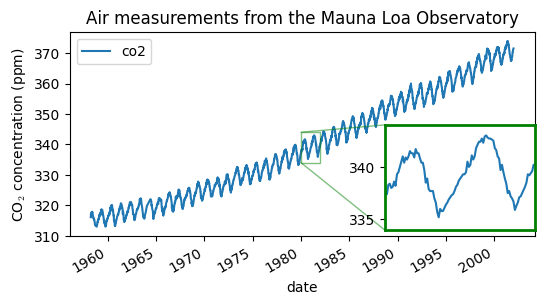

In [176]:
from datetime import datetime

fig, ax = plt.subplots(figsize=(6, 3))
co2_data.plot(ax=ax)
ax.set_ylabel("CO$_2$ concentration (ppm)")
ax.set_title("Air measurements from the Mauna Loa Observatory")

axin = fig.add_axes([0.65, 0.22, 0.25, 0.35])
co2_data.plot(ax=axin, legend=False)
axin.set(xticks=[], xlabel="")
axin.set_xlim(datetime(1980, 1, 1), datetime(1981, 12, 31))
axin.set_ylim(334, 344)
axin.spines[:].set_color("green")
axin.spines[:].set_linewidth(2)
ax.indicate_inset_zoom(axin, edgecolor="green")

fig.savefig("./122_gpr2_11.png")

In [193]:
date_start = datetime(1958, 3, 29)
X = (co2_data.index - date_start).days.values
y = co2_data["co2"].values

print(f"X = {X}\ny = {y}")

X = [    0     7    14 ... 15967 15974 15981]
y = [316.1 317.3 317.6 ... 371.2 371.3 371.5]


In [194]:
today = (datetime.now() - date_start).days
X_today = 7*np.linspace(0, today//7, today//7+1, dtype=int)
X_today

array([    0,     7,    14, ..., 23590, 23597, 23604])

In [229]:
from datetime import timedelta

dates_today = []
for x in X_today:
    dates_today.append(date_start + timedelta(days=int(x)))

## Long-term trend

In [226]:
# long term trend : RBF with large length scale
kernel_long = (50.0*365)**2 * RBF(length_scale=(50.0*365))

/opt/conda/envs/py39/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/conda/envs/py39/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


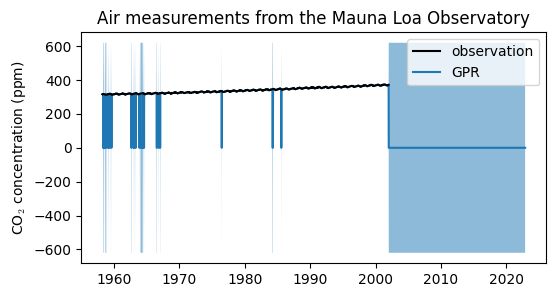

In [227]:
gpr_co2_long = GaussianProcessRegressor(kernel_long, n_restarts_optimizer=9, random_state=0)
gpr_co2_long.fit(X.reshape(-1, 1), y)
y_long_pred_mean, y_long_pred_std = gpr_co2_long.predict(X_today.reshape(-1, 1), return_std=True)

fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(co2_data.index, co2_data["co2"], c="k", label="observation", zorder=2)
ax.plot(dates_today, y_long_pred_mean, c="C0", label="GPR", zorder=-1)
ax.fill_between(dates_today, y_long_pred_mean-1.96*y_long_pred_std, y_long_pred_mean+1.96*y_long_pred_std, fc="C0", alpha=0.5, zorder=-1)

ax.set_ylabel("CO$_2$ concentration (ppm)")
ax.set_title("Air measurements from the Mauna Loa Observatory")
ax.legend()

fig.savefig("./122_gpr2_12.png")

In [228]:
gpr_co2_long.kernel_

316**2 * RBF(length_scale=1e-05)

## +Seasonal trend

In [231]:
# seasonal trend : RBF x ExpSineSquared
kernel_season = (
    2.0**2
    * RBF(length_scale=100.0*365)
    * ExpSineSquared(length_scale=365.0, periodicity=365.0, periodicity_bounds="fixed")
)

kernel = kernel_long + kernel_season
kernel

1.82e+04**2 * RBF(length_scale=1.82e+04) + 2**2 * RBF(length_scale=3.65e+04) * ExpSineSquared(length_scale=365, periodicity=365)

/opt/conda/envs/py39/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:432: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(


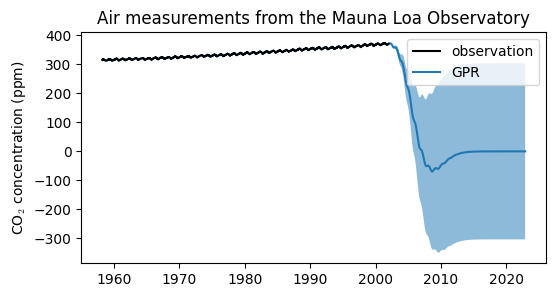

In [235]:
gpr_co2_season = GaussianProcessRegressor(kernel, n_restarts_optimizer=9, random_state=0)
gpr_co2_season.fit(X.reshape(-1, 1), y)
y_season_pred_mean, y_season_pred_std = gpr_co2_season.predict(X_today.reshape(-1, 1), return_std=True)

fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(co2_data.index, co2_data["co2"], c="k", label="observation", zorder=2)
ax.plot(dates_today, y_season_pred_mean, c="C0", label="GPR", zorder=-1)
ax.fill_between(dates_today, y_season_pred_mean-1.96*y_season_pred_std, y_season_pred_mean+1.96*y_season_pred_std, fc="C0", alpha=0.5, zorder=-1)

ax.set_ylabel("CO$_2$ concentration (ppm)")
ax.set_title("Air measurements from the Mauna Loa Observatory")
ax.legend()

fig.savefig("./122_gpr2_13.png")

In [236]:
gpr_co2_season.kernel_

0.38**2 * RBF(length_scale=0.238) + 155**2 * RBF(length_scale=1.12e+03) * ExpSineSquared(length_scale=14.1, periodicity=365)

## + Irregularities and Noise

In [238]:
# irregularities
kernel_irr = 0.5**2 * RationalQuadratic(length_scale=365.0, alpha=1.0)

# noise
kernel_noise = 0.1**2 * RBF(length_scale=30) + \
               WhiteKernel(noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5))

kernel = kernel_long + kernel_season + kernel_irr + kernel_noise
kernel

1.82e+04**2 * RBF(length_scale=1.82e+04) + 2**2 * RBF(length_scale=3.65e+04) * ExpSineSquared(length_scale=365, periodicity=365) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=365) + 0.1**2 * RBF(length_scale=30) + WhiteKernel(noise_level=0.01)

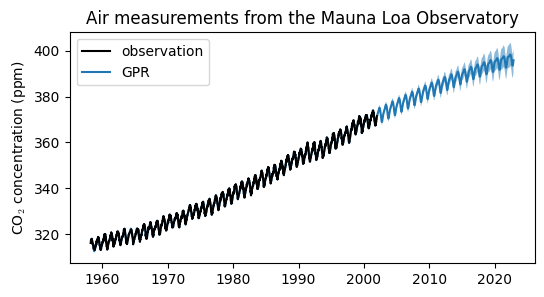

In [239]:
gpr_co2 = GaussianProcessRegressor(kernel, n_restarts_optimizer=9, random_state=0)
gpr_co2.fit(X.reshape(-1, 1), y)
y_pred_mean, y_pred_std = gpr_co2.predict(X_today.reshape(-1, 1), return_std=True)

fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(co2_data.index, co2_data["co2"], c="k", label="observation", zorder=2)
ax.plot(dates_today, y_pred_mean, c="C0", label="GPR", zorder=-1)
ax.fill_between(dates_today, y_pred_mean-1.96*y_pred_std, y_pred_mean+1.96*y_pred_std, fc="C0", alpha=0.5, zorder=-1)

ax.set_ylabel("CO$_2$ concentration (ppm)")
ax.set_title("Air measurements from the Mauna Loa Observatory")
ax.legend()

fig.savefig("./122_gpr2_14.png")

In [240]:
gpr_co2.kernel_

0.339**2 * RBF(length_scale=1.54e-05) + 194**2 * RBF(length_scale=3.4e+04) * ExpSineSquared(length_scale=5.25, periodicity=365) + 0.00321**2 * RationalQuadratic(alpha=65.8, length_scale=0.0394) + 0.457**2 * RBF(length_scale=103) + WhiteKernel(noise_level=4e-05)